# Tech Challenge -> Dados Bolsa de Valores

## <b>Target</b> : Prever se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual

## Mandatório:

- O conjunto de **teste obrigatório** é o último mês (30 dias).
- O modelo precisa atingir **mínimo de 75% de acurácia** nesse período

### Importação de Bibliotecas

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, balanced_accuracy_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import clone

import optuna
from optuna.pruners import MedianPruner
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import optuna
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from prophet import Prophet
import yfinance as yf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
# --- IGNORE ---


c:\Users\gpira\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregamento e exploração inicial

In [34]:

df = pd.read_csv(r"..\..\Dados Históricos - Ibovespa(2).csv", sep=',')

In [35]:
df.shape

(769, 7)

In [36]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      769 non-null    object 
 1   Último    769 non-null    float64
 2   Abertura  769 non-null    float64
 3   Máxima    769 non-null    float64
 4   Mínima    769 non-null    float64
 5   Vol.      769 non-null    object 
 6   Var%      769 non-null    object 
dtypes: float64(4), object(3)
memory usage: 42.2+ KB


In [37]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,06.10.2025,143.608,144.202,144.532,143.376,"5,98B","-0,41%"
1,03.10.2025,144.201,143.950,144.518,143.676,"6,18B","0,17%"
2,02.10.2025,143.950,145.517,145.621,143.635,"7,25B","-1,08%"
3,01.10.2025,145.517,146.237,146.879,145.193,"8,34B","-0,49%"
4,30.09.2025,146.237,146.337,147.578,145.774,"9,48B","-0,07%"


In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Último,769.0,123.307568,10.644694,97.926,115.488,125.572,130.834,146.492
Abertura,769.0,123.263853,10.630508,97.926,115.404,125.531,130.826,146.492
Máxima,769.0,124.152083,10.546360,99.258,116.203,126.399,131.606,147.578
Mínima,769.0,122.453446,10.734313,96.997,114.485,124.637,130.115,146.067


In [39]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

### Limpeza dos dados

In [40]:
df['Data']=pd.to_datetime(df['Data'],format='%d.%m.%Y')

In [41]:
#Corrije variação percentual
df['Var%']=df['Var%'].apply(lambda x: str(x[:len(x)-1]).replace(',','.'))

In [42]:
#Corrije vol
df['Vol.']=df['Vol.'].apply(lambda x: float(str(str(x).strip().upper().replace(',','.')[:-1]))*1_000_000 if str(x).strip().upper().replace(',','.').endswith('M') 
                                else float(str(str(x).strip().upper().replace(',','.')[:-1]))*1_000_000 if str(x).strip().upper().replace(',','.').endswith('B')
                                else x )

In [1]:
#Variaveis de data
df['ano']=df['Data'].dt.year
df['mes']=df['Data'].dt.month
df['dow']=df['Data'].dt.day_of_week
df['Anomes']=df['Data'].dt.strftime('%m.%y')

NameError: name 'df' is not defined

### Análise Exploratória

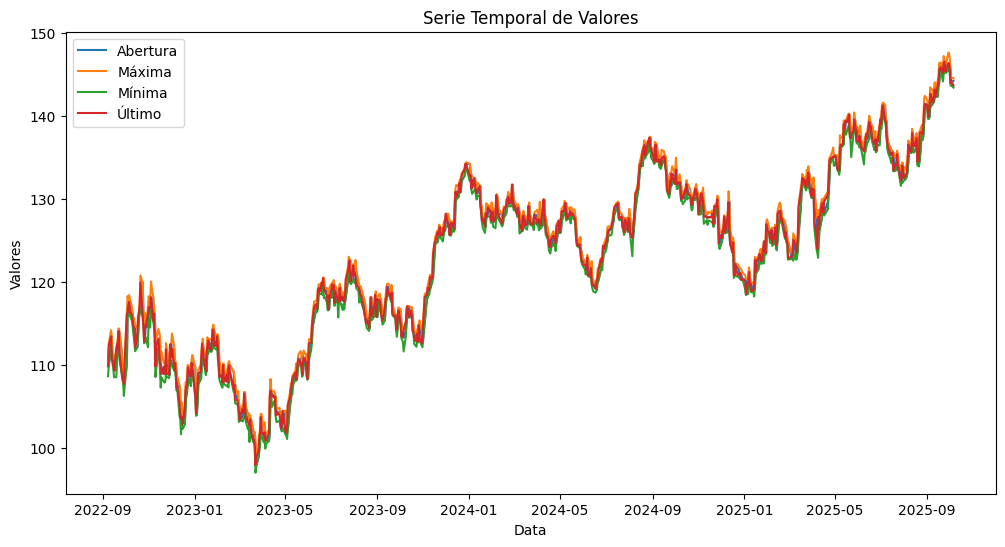

In [45]:
plt.figure(figsize=(12,6))
for col in ['Abertura','Máxima','Mínima','Último']:
  sns.lineplot(data=df,x='Data',y=col,label=col)
plt.title("Serie Temporal de Valores")
plt.xlabel("Data")
plt.ylabel("Valores")
plt.legend()
plt.show()

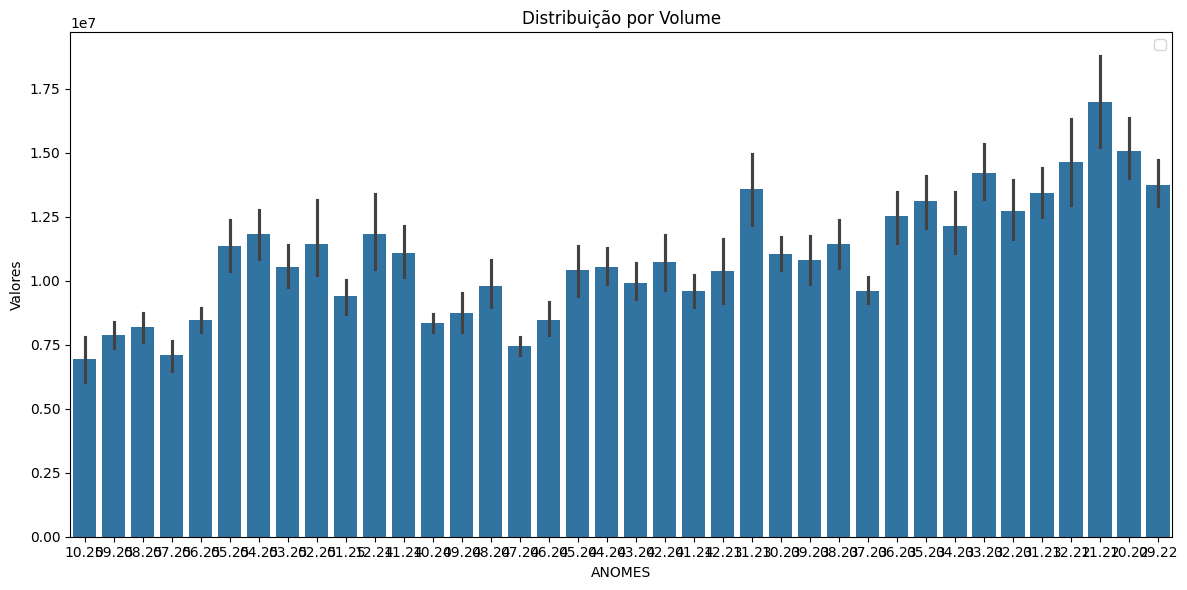

In [46]:
plt.figure(figsize=(12,6))
sns.barplot(data=df,x='Anomes',y='Vol.')
plt.title("Distribuição por Volume")
plt.xlabel("ANOMES")
plt.ylabel("Valores")
plt.tight_layout()
plt.legend()
plt.show()

Text(0, 0.5, 'Valores')

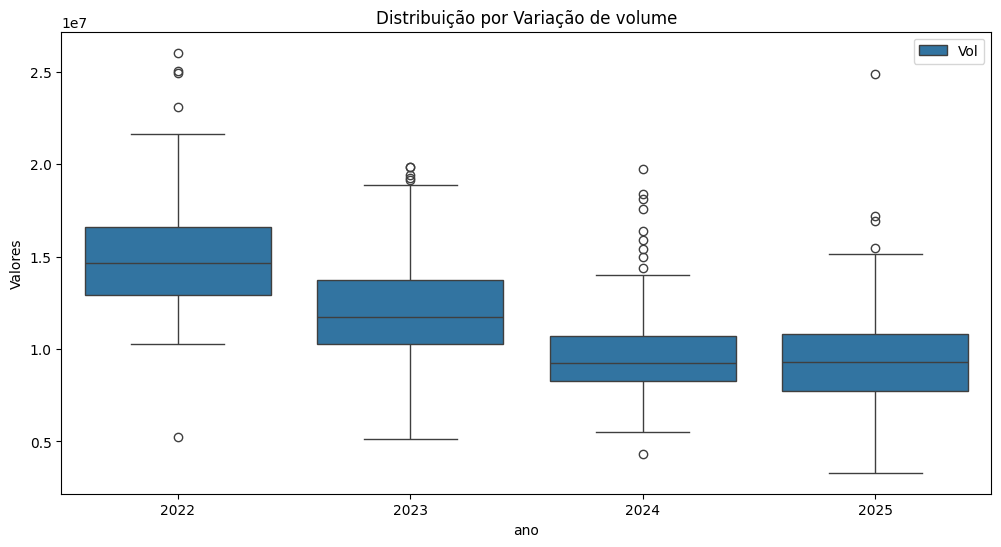

In [47]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df,x='ano',y='Vol.',label='Vol')
plt.title("Distribuição por Variação de volume")

plt.ylabel("Valores")

Histograma do volume


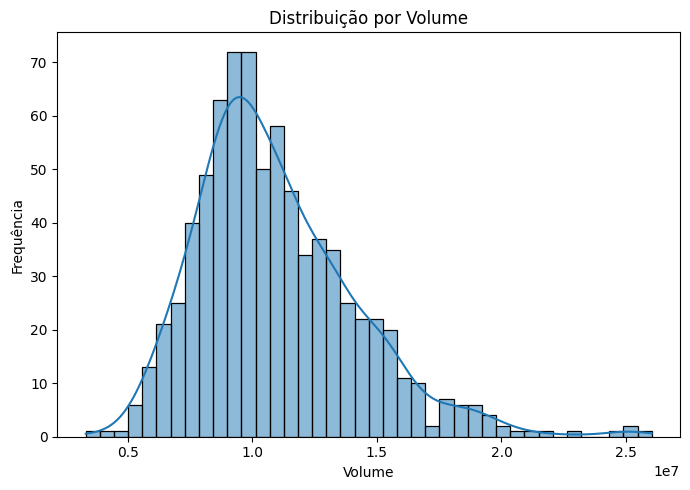

In [48]:

plt.figure(figsize=(7,5))
sns.histplot(df['Vol.'],bins=40, kde=True)
plt.title("Distribuição por Volume")
plt.xlabel("Volume")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

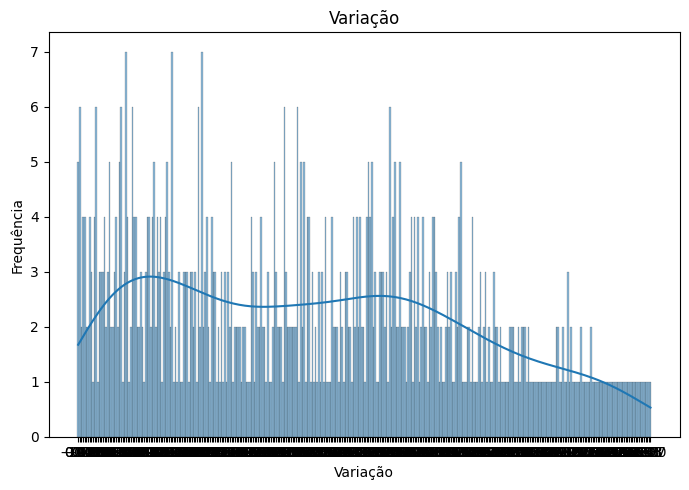

In [49]:
plt.figure(figsize=(7,5))
sns.histplot(df['Var%'],bins=40,kde=True)
plt.title("Variação")
plt.xlabel("Variação")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

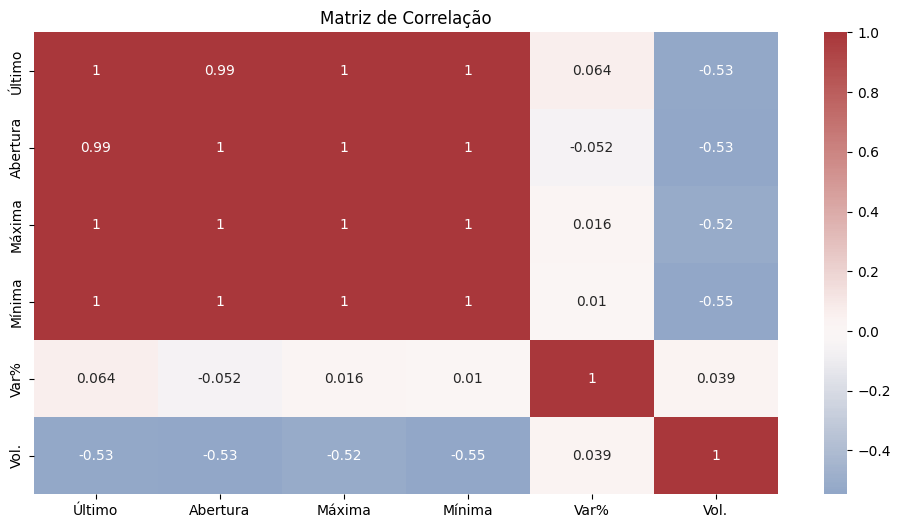

In [50]:
num_cols = ['Último','Abertura','Máxima','Mínima','Var%','Vol.']

plt.figure(figsize=(12,6))
corr=df[num_cols].corr()
sns.heatmap(corr,annot=True,cmap='vlag',center=0)
plt.title("Matriz de Correlação")
plt.show()

### Funções de criação de features e metricas


In [20]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

In [21]:
#Definição de médias moveis simples e exponenciais
def create_features(df, close_col='Último'):
    df=df.copy()
    df = df.sort_values('Data').reset_index(drop=True)
    df['ret_1']=df[close_col].pct_change()
    
    for w in [5,10,20,50,100]:
        df[f'mm_{w}']=df['Último'].rolling(window=w).mean()
        df[f'spread_mm{w}']=df['Último']-df[f'mm_{w}']
        df[f'vol_{w}']=df['Vol.'].rolling(window=w).mean()
        df[f'ema_{w}']=df['Último'].ewm(span=w, adjust=False).mean()
    # indicadores adicionais de momentum e relações de preço
    eps = 1e-9
    df['close_over_mm5'] = df['Último'] / (df['mm_5'] + eps) - 1
    df['close_over_mm10'] = df['Último'] / (df['mm_10'] + eps) - 1
    df['close_over_mm20'] = df['Último'] / (df['mm_20'] + eps) - 1
    df['close_over_mm50'] = df['Último'] / (df['mm_50'] + eps) - 1
    df['close_over_mm100'] = df['Último'] / (df['mm_100'] + eps) - 1

    df['momentum_3'] = df['Último'].pct_change(3)
    df['momentum_5'] = df['Último'].pct_change(5)
    df['momentum_10'] = df['Último'].pct_change(10)

    df['var_shift_1'] = df['Var%'].shift(1)
    df['var_shift_2'] = df['Var%'].shift(2)

    df['vol_ratio_5_20'] = (df['vol_5'] / (df['vol_20'].replace(0, np.nan))).fillna(0.0)



    df.fillna(0,inplace=True)
    
    return df

In [51]:
df=create_features(df)

In [52]:
from sklearn.feature_selection import SelectKBest, f_regression
def select_features(train,test,target='Último',k=10):
    feature_cols=[col for col in train.columns if col !=target and col != 'Data']
    train = train[feature_cols + [target]].dropna()
    test = test[feature_cols].dropna()
    X_train = train[feature_cols]
    X_test = test[feature_cols]
    y_train = train[target]
    
    X_train.dropna(inplace=True)

    scaler= StandardScaler()
    X_train_scaled= scaler.fit_transform(X_train)
    X_test_scaled= scaler.transform(X_test)

    selector= SelectKBest(score_func=f_regression,k=k)
    X_train_selected= selector.fit_transform(X_train_scaled,y_train)    
    X_test_selected= selector.transform(X_test_scaled)

    selected_features= X_train.columns[selector.get_support()]
    print("Selected Features:", selected_features.tolist())
    return selected_features,scaler,selector

### Auto Regressão


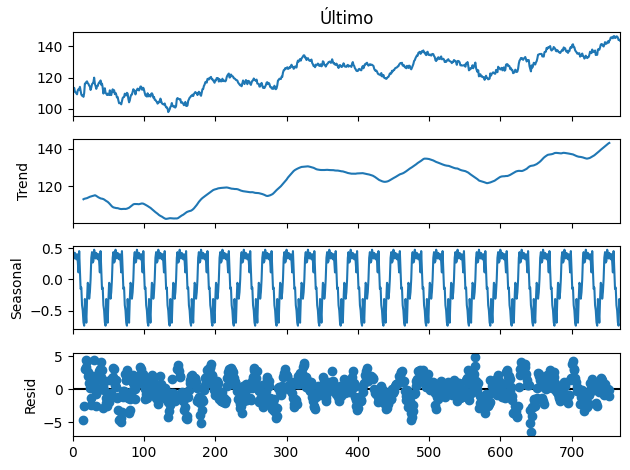

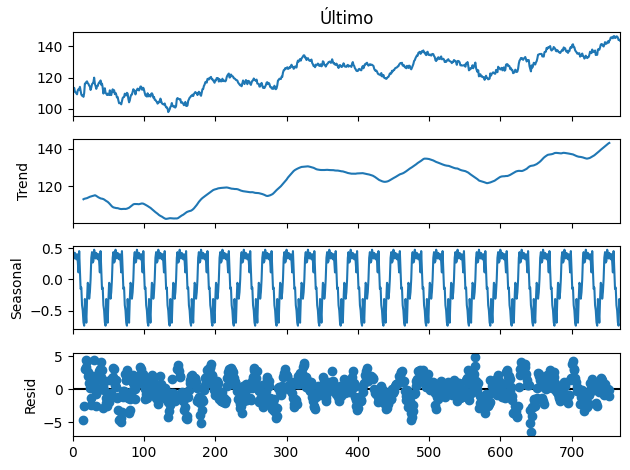

In [66]:
result= seasonal_decompose(df['Último'], model='additive', period=30)
result.plot()

Auto correlação


In [67]:
# acf
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf


def plot_acf(data, lags=365, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    # Get the ACF values and confidence intervals
    _plot_acf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(data, alpha=0.05, nlags=365)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The ACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The ACF coefficients do not intercept the threshold")


The ACF coefficients intercept the threshold at lag 59


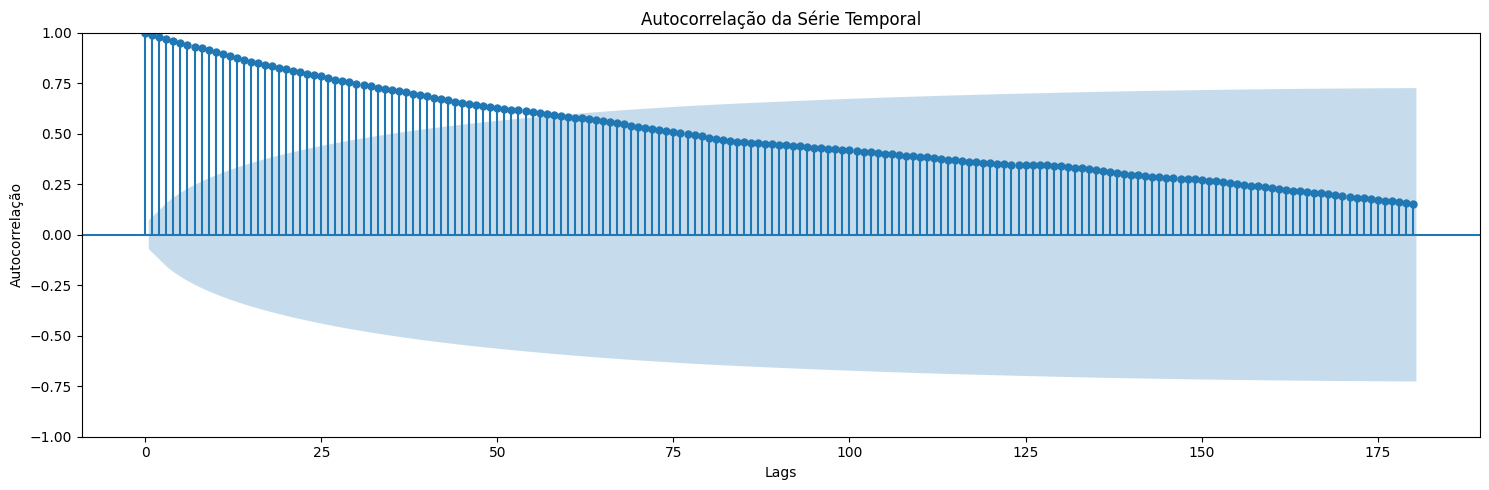

In [68]:
plot_acf(df["Último"], lags=180)

Auto correlação Parcial

In [69]:
# acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf


def plot_pacf(data, lags=30, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    # Get the ACF values and confidence intervals
    _plot_pacf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(data, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The PACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The PACF coefficients do not intercept the threshold")

The PACF coefficients intercept the threshold at lag 2


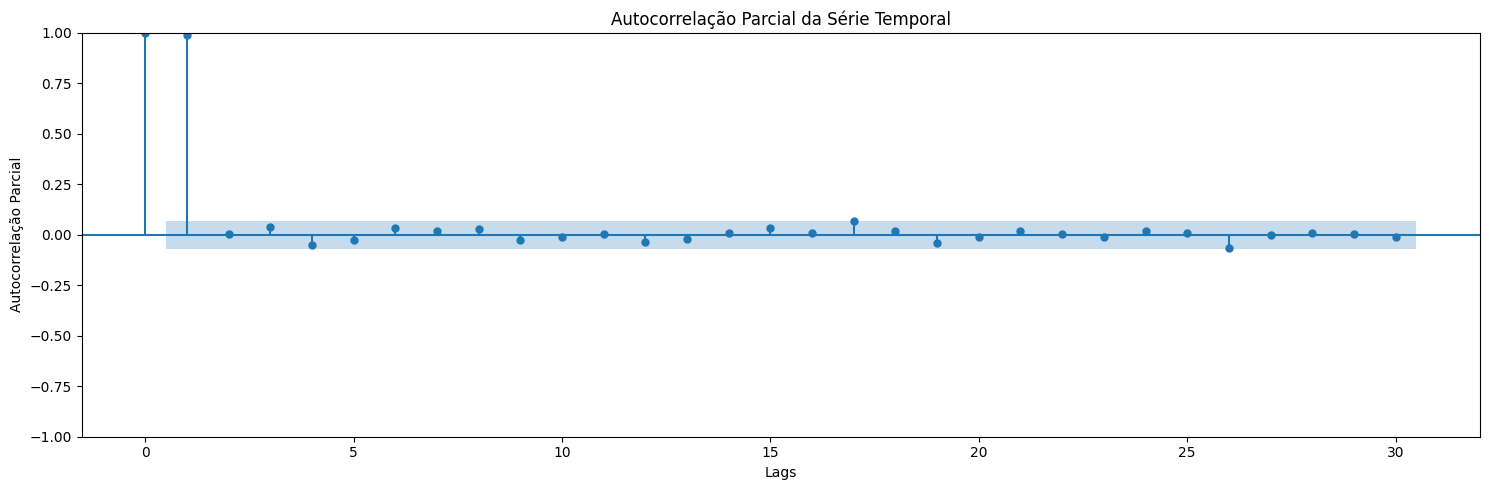

In [70]:
plot_pacf(df["Último"])

In [71]:
adf_result = sm.tsa.adfuller(df["Último"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -1.3003328042879954
p-value: 0.6290200415624974
Critical Values: {'1%': -3.4388933482333464, '5%': -2.8653106782623574, '10%': -2.5687778874376086}
A série temporal não é estacionária


<Axes: >

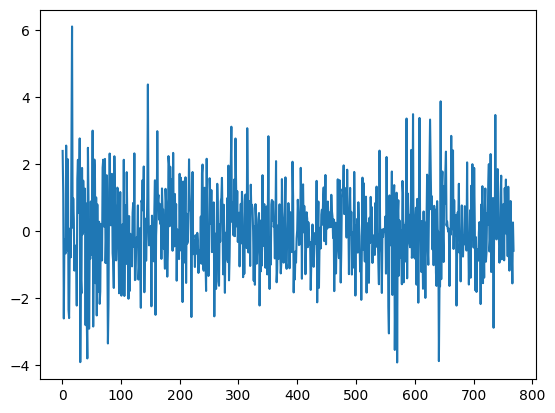

In [72]:
df['Último'].diff().plot()

In [73]:
# diferenciando 1 vez

adf_result = sm.tsa.adfuller(df["Último"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -27.67490069838278
p-value: 0.0
Critical Values: {'1%': -3.4389045244994096, '5%': -2.8653156040031176, '10%': -2.5687805115003}
A série temporal é estacionária


In [74]:
acf_x = sm.tsa.acf(df["Último"], alpha=0.05, nlags=365)
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(df["Último"], alpha=0.05, nlags=30)
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

In [75]:
# parâmetros do modelo ARIMA
p, q, d

(2, 59, 1)

In [76]:
model = pm.auto_arima(
    df["Último"],
    seasonal=True,
    m=12,
    stepwise=True,
)

# Summary of the model's detected parameters
print(model.summary())

# Detected seasonal order
seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  769
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1256.211
Date:                Mon, 13 Oct 2025   AIC                           2514.421
Time:                        11:36:14   BIC                           2519.065
Sample:                             0   HQIC                          2516.208
                                - 769                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5426      0.064     24.103      0.000       1.417       1.668
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                35.23
Prob(Q):                              0.97   Pr

### Separação de dataset entre treino e teste

In [55]:

train_size = df.shape[0] - 30
train,test= df[:train_size], df[-30:]

In [56]:
train

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,ano,mes,dow,...,close_over_mm10,close_over_mm20,close_over_mm50,close_over_mm100,momentum_3,momentum_5,momentum_10,var_shift_1,var_shift_2,vol_ratio_5_20
0,2022-09-08,109.916,109.771,110.768,108.619,13760000.0,0.14,2022,9,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000
1,2022-09-09,112.300,109.922,112.540,109.922,12160000.0,2.17,2022,9,4,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.14,0,0.000000
2,2022-09-12,113.407,112.307,114.160,112.305,11710000.0,0.98,2022,9,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.17,0.14,0.000000
3,2022-09-13,110.794,113.398,113.400,110.522,12610000.0,-2.30,2022,9,1,...,0.000000,0.000000,0.000000,0.000000,0.007988,0.000000,0.000000,0.98,2.17,0.000000
4,2022-09-14,110.547,110.794,111.504,110.118,11630000.0,-0.22,2022,9,2,...,0.000000,0.000000,0.000000,0.000000,-0.015610,0.000000,0.000000,-2.30,0.98,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2025-08-19,134.432,137.321,137.321,133.997,8680000.0,-2.10,2025,8,1,...,-0.012730,-0.002297,-0.013395,-0.005612,-0.014110,-0.025248,0.009621,0.72,-0.01,1.138066
735,2025-08-20,134.666,134.430,134.964,134.122,6850000.0,0.17,2025,8,2,...,-0.011105,-0.000300,-0.011421,-0.003993,-0.012285,-0.014786,0.000951,-2.10,0.72,1.071599
736,2025-08-21,134.511,134.664,134.837,133.874,6520000.0,-0.12,2025,8,3,...,-0.010778,-0.001711,-0.012179,-0.005332,-0.020470,-0.013531,-0.014774,0.17,-2.10,0.988964
737,2025-08-22,137.968,134.511,138.072,134.511,9320000.0,2.57,2025,8,4,...,0.013115,0.022260,0.013183,0.019651,0.026303,0.011933,0.015120,-0.12,0.17,0.966920


In [57]:
test

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,ano,mes,dow,...,close_over_mm10,close_over_mm20,close_over_mm50,close_over_mm100,momentum_3,momentum_5,momentum_10,var_shift_1,var_shift_2,vol_ratio_5_20
739,2025-08-26,137.771,138.026,138.037,137.058,8450000.0,-0.18,2025,8,1,...,0.009993,0.016679,0.011837,0.017183,0.024236,0.024838,-0.001037,0.04,2.57,0.901597
740,2025-08-27,139.206,137.773,139.281,137.456,6610000.0,1.04,2025,8,2,...,0.018632,0.025296,0.022321,0.027166,0.008973,0.033713,0.018429,-0.18,0.04,0.907057
741,2025-08-28,141.049,139.206,142.138,139.206,9290000.0,1.32,2025,8,3,...,0.028585,0.035827,0.035501,0.039707,0.021909,0.048606,0.034417,1.04,-0.18,0.974627
742,2025-08-29,141.422,141.049,142.379,141.000,9330000.0,0.26,2025,8,4,...,0.027498,0.035151,0.037583,0.041241,0.026500,0.025035,0.037267,1.32,1.04,0.969927
743,2025-09-01,141.283,141.423,141.950,140.878,4950000.0,-0.10,2025,9,0,...,0.023543,0.030997,0.035844,0.038891,0.014920,0.023604,0.028845,0.26,1.32,0.951419
744,2025-09-02,140.335,141.279,141.279,139.625,8790000.0,-0.67,2025,9,1,...,0.012346,0.021402,0.028416,0.030969,-0.005062,0.018611,0.043911,-0.10,0.26,0.947081
745,2025-09-03,139.864,140.332,140.496,139.582,7580000.0,-0.34,2025,9,2,...,0.005179,0.016005,0.024349,0.026490,-0.011017,0.004727,0.038599,-0.67,-0.10,0.977185
746,2025-09-04,140.993,139.832,141.482,139.832,8030000.0,0.81,2025,9,3,...,0.008594,0.022548,0.032031,0.033766,-0.002053,-0.000397,0.048189,-0.34,-0.67,0.954944
747,2025-09-05,142.640,141.003,143.409,141.003,8380000.0,1.17,2025,9,4,...,0.016977,0.031975,0.043205,0.044832,0.016425,0.008613,0.033863,0.81,-0.34,0.940253
748,2025-09-08,141.792,142.640,143.089,141.329,7440000.0,-0.59,2025,9,0,...,0.008223,0.023556,0.036558,0.037667,0.013785,0.003603,0.027292,1.17,0.81,0.999255


In [58]:
test.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [59]:
train.shape, test.shape

((739, 43), (30, 43))

In [60]:
selected_features,scaler,selector=select_features(train,test,k=10)

Selected Features: ['Abertura', 'Máxima', 'Mínima', 'ano', 'mm_5', 'ema_5', 'ema_10', 'ema_20', 'ema_50', 'ema_100']


In [63]:
exog_train = train[selected_features.tolist()]
exog_test= test[selected_features.tolist()]



In [77]:
# # Modelo SARIMAX



model = sm.tsa.statespace.SARIMAX(
    train["Último"],
    exog=exog_train,
    order=(
        p,
        d,
        q,
    ), 
    seasonal_order=seasonal_order,
)
results = model.fit()

preds = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean



In [78]:
metrics_sarimax = calculate_metrics(test["Último"], preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

SARIMAX Metrics:
MAE: 3.8682927527938347
MSE: 17.991573521619014
MAPE: 2.68 %


###  Modelo PROPHET

In [79]:
#Modelo Prophet
train_prophet = train.rename(columns={"Data": "ds", "Último": "y"})
test_prophet = test.rename(columns={"Data": "ds", "Último": "y"})

In [80]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
for c in selected_features.tolist():
    model.add_regressor(c)

model.fit(train_prophet)


future = model.make_future_dataframe(periods=len(test))
future[selected_features.tolist()] = pd.concat([train_prophet[selected_features.tolist()], test_prophet[selected_features.tolist()]], ignore_index=True)
forecast = model.predict(future)
preds_prophet = forecast['yhat'].iloc[-len(test):].values

11:39:56 - cmdstanpy - INFO - Chain [1] start processing
11:39:58 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
metrics_prophet = calculate_metrics(test["Último"], preds_prophet)
print("Prophet Metrics:")
print_metrics(metrics_prophet)

Prophet Metrics:
MAE: 0.6689562498964411
MSE: 0.719583976598205
MAPE: 0.47 %


### Verificando Resultados

In [82]:
test['prophet']=np.array(preds_prophet)
test['sarimax']=np.array(preds)


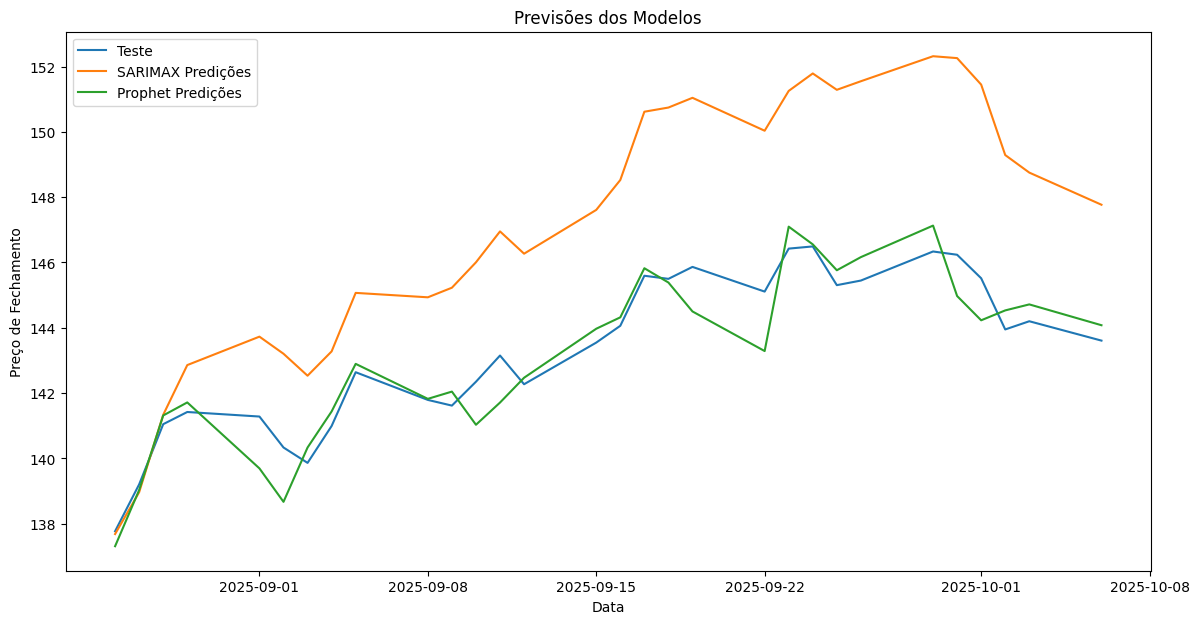

In [84]:
# plotando as predições 
plt.figure(figsize=(14, 7))

plt.plot(test["Data"], test["Último"], label="Teste")
plt.plot(test["Data"], test['sarimax'], label="SARIMAX Predições")
# plt.plot(test["Data"], pred_xgboost, label="XGBoost Predições")
plt.plot(test_prophet["ds"], test['prophet'], label="Prophet Predições")
plt.title("Previsões dos Modelos")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()

SARIMAX Accuracy: 0.5517241379310345
Prophet Accuracy: 0.8620689655172413


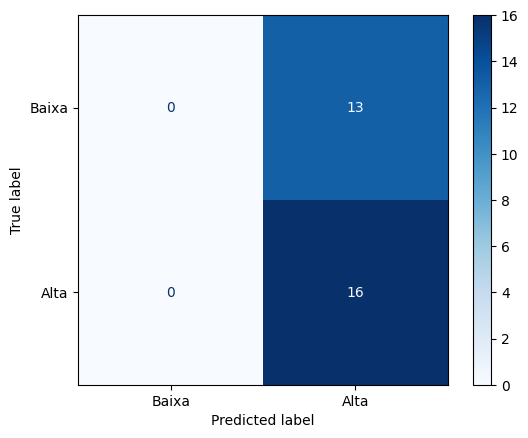

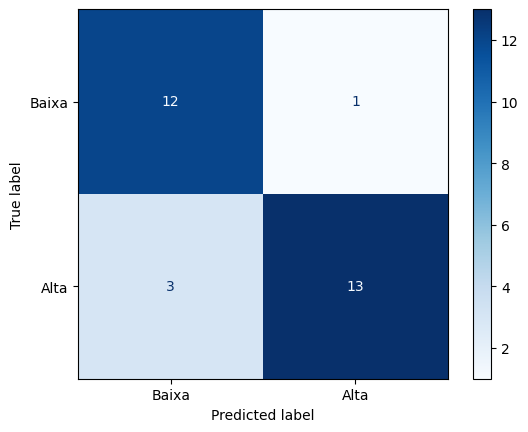

In [ ]:
#Transformando em predicts em variaveis categoricas para calcular acurácia
real_up = (test["Último"] - test["Último"].shift(1)) > 0
sarimax_up = (test['sarimax'] - test["Último"].shift(1)) > 0
prophet_up = (test['prophet'] - test["Último"].shift(1)) > 0

#chamando a matriz de confusão
cm_sarimax = confusion_matrix(real_up[1:], sarimax_up[1:])
cm_prophet = confusion_matrix(real_up[1:], prophet_up[1:])
cm_sarimax_display = ConfusionMatrixDisplay(cm_sarimax, display_labels=["Baixa", "Alta"])
cm_prophet_display = ConfusionMatrixDisplay(cm_prophet, display_labels=["Baixa", "Alta"])

print(f"SARIMAX Accuracy: {accuracy_score(real_up[1:], sarimax_up[1:])}")
cm_sarimax_display.plot(cmap="Blues")

print(f"Prophet Accuracy: {accuracy_score(real_up[1:], prophet_up[1:])}")
cm_prophet_display.plot(cmap="Blues")
